In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciv_sepsis_mortality/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [6]:
import importlib
import medical_explainer_classic
importlib.reload(medical_explainer_classic)

explainer = medical_explainer_classic.explainer(
    X_train, y_train, X_test, y_test
)

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Select top 10 features for fair comparison
top_n = 10

scaler = MinMaxScaler()
select = SelectKBest(chi2, k=top_n)
select.fit(scaler.fit_transform(X_train), y_train)
selected_features = select.get_feature_names_out(X_train.columns)


In [8]:
from pygam import LogisticGAM, s, f

equation = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9)

gam = LogisticGAM(equation).fit(X_train[selected_features], y_train)

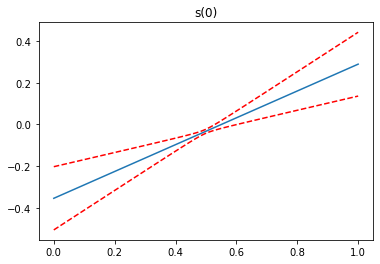

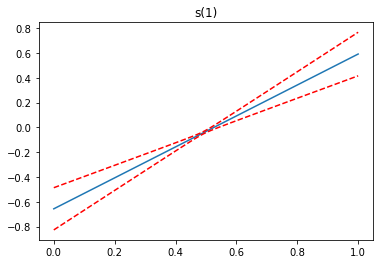

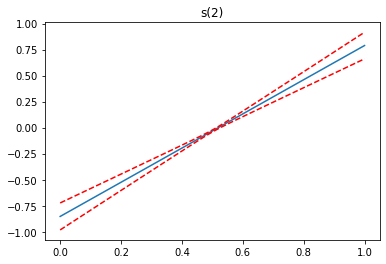

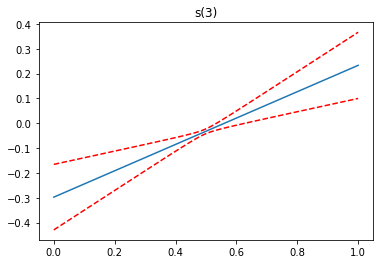

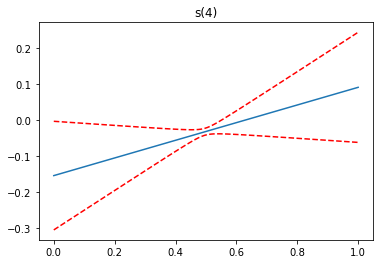

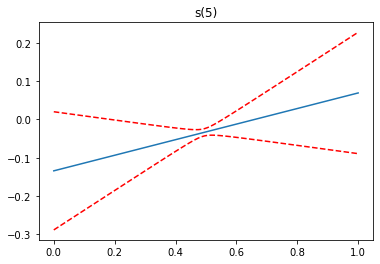

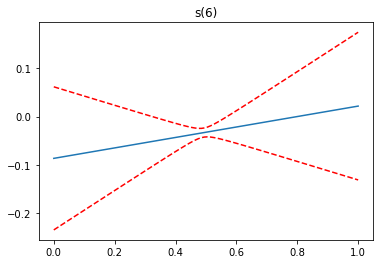

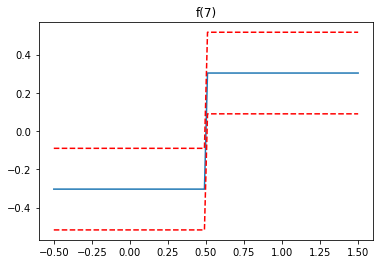

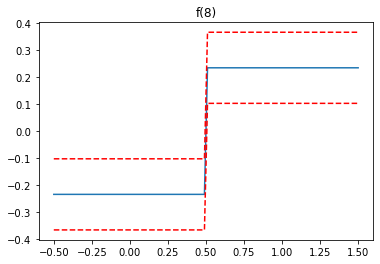

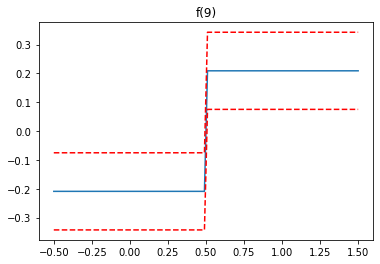

In [9]:
import matplotlib.pyplot as plt


for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [10]:
import importlib
import medical_explainer_classic
importlib.reload(medical_explainer_classic)

explainer = medical_explainer_classic.explainer(
    X_train, y_train, X_test, y_test
)

| Step 1 ==> Selecting top n features
| Step 2 ==> Transforming features based on GAM
| Step 3 ==> Fitting logistic regression model on transformed categories
| Step 4 ==> Calibrating logistic regression model


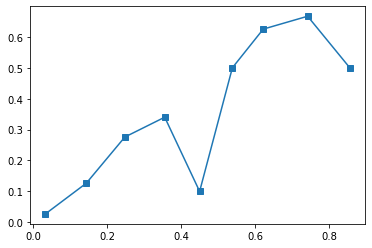

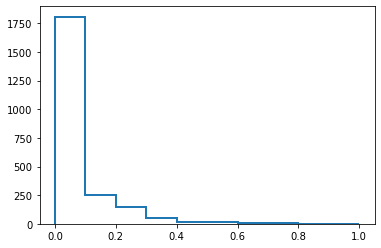

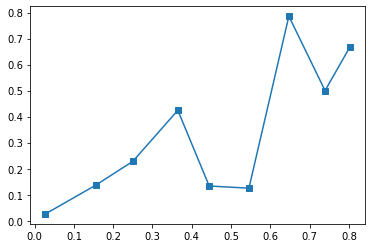

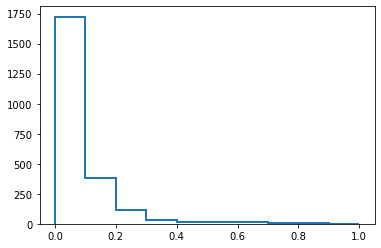

| Step 5 ==> Fit clinical score calculator
Fit clincal score calculator
Threshold:0.1
4

Threshold:0.5
9

Threshold:0.9
14



In [11]:
from sklearn.model_selection import StratifiedKFold

print('| Step 1 ==> Selecting top n features')
explainer.selected_features = selected_features

print('| Step 2 ==> Transforming features based on GAM')
explainer.find_features_categories_gam(equation)

print('| Step 3 ==> Fitting logistic regression model on transformed categories')
explainer.fit_logreg()

print('| Step 4 ==> Calibrating logistic regression model')

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

explainer.plot_calibration_original()
explainer.calibrate(cv=skf)
explainer.plot_calibration_calibrated()

print('| Step 5 ==> Fit clinical score calculator')
explainer.fit_calculator()

In [12]:
explainer.scores

array([2., 3., 4., 1., 1., 0., 0., 1., 1., 1.])

In [13]:
explainer.selected_features

array(['malignant_cancer', 'metastatic_solid_tumor', 'time2bg_24hr_flag',
       'ed_medgp_cardiovascular', 'ed_medgp_multiple',
       'ed_medgp_nervous_system', 'ed_a_cefepime',
       'ed_a_metronidazole_flagyl', 'ed_a_vancomycin',
       'antibiotic_a_lesse1'], dtype=object)

In [14]:
explainer.breakpoints_list

[[0.0, 0.5502223442767249, 1.0],
 [0.0, 0.5258943496140396, 1.0],
 [0.0, 0.5196953154478494, 1.0],
 [0.0, 0.5609277579988217, 1.0],
 [0.0, 0.6318233851199508, 1.0],
 [0.0, 0.6591293553659197, 1.0],
 [0.0, 0.7988448634571094, 1.0],
 [-0.5, 0.500000000267051, 1.5],
 [-0.5, 0.500000000346035, 1.5],
 [-0.5, 0.5000000003878033, 1.5]]

In [15]:
explainer.beta_values

array([0.62305764, 1.1914809 , 1.59326125, 0.51249255, 0.24009921,
       0.19895643, 0.11073153, 0.57293051, 0.45234367, 0.4100686 ])

In [16]:
scores, probs, predictions = explainer.predict_calculator(X_test, threshold_choice=1)

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.8313183232113761
Average Precision: 0.27039558169085587
Accuracy: 0.9271781534460338
[[2120   30]
 [ 138   19]]


In [18]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [19]:
y_test = y_test.reset_index(drop=True)

In [20]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]
    
    scores_bs = scores[X_test_bs.index]
    probs_bs = probs[X_test_bs.index]
    predictions_bs = predictions[X_test_bs.index]

    # scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs_bs)
    auprc = average_precision_score(y_test_bs, probs_bs)
    accuracy = accuracy_score(y_test_bs, predictions_bs)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8210176651305684, 0.8053920483795078, 0.836643281881629)
(0.2830065310864703, 0.259414802143035, 0.3065982600299056)
(0.9248000000000001, 0.9226333377319292, 0.9269666622680709)
